# PROJECT 1: Image classification using CNN.

###Vishala Vemuri: NetID - vxv230006</br>
###Megha Chandrasekharan Nair: NetID - mxc220113</br>
###Swapnil Kaner: NetID - ssk230013

## Importing the required libraries.


In [1]:
!pip install torchmetrics
!pip install torchinfo
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=52c84f842eaa6623ff548e8b4c7526d513a8755086dc4205480a9310906a9d43
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics.classification import Accuracy
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

# Import matplotlib for visualization
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns


# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


# **Loading the CIFAR10 dataset.**

### <font color = 'Orange'>  **Transformation and Normalization on data**

In [3]:
# Transform with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

# Setup training data with normalization
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# Setup testing data with normalization
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:11<00:00, 14.5MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
# Total data that we have is:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

### <font color = 'Orange'>  **Data Splitting to Training and Validation dataset**

In [5]:
from torch.utils.data import random_split

torch.manual_seed(42)

# Define the split ratio
train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

Let's check out the first sample of the training data.

In [6]:
# See first training sample
image, label = train_dataset[0]
image, label

(tensor([[[-1.2466, -1.0527, -0.9170,  ..., -0.9170, -1.0527, -1.3047],
          [-0.2192, -0.3161, -0.6263,  ..., -0.8395, -1.0527, -1.2660],
          [-0.8783, -1.1497, -1.4792,  ..., -0.6069, -0.6457, -0.8589],
          ...,
          [-2.3515, -2.3128, -2.4291,  ..., -0.2386, -0.4130, -0.2386],
          [-2.2740, -2.1577, -2.3128,  ..., -0.1416, -0.5487, -0.6844],
          [-1.6924, -1.6924, -1.8669,  ..., -0.5681, -0.8007, -0.6650]],
 
         [[-1.2972, -1.1989, -1.0416,  ..., -1.1399, -1.2776, -1.4939],
          [-0.2746, -0.4516, -0.7072,  ..., -0.9826, -1.2186, -1.4152],
          [-0.9236, -1.2382, -1.4546,  ..., -0.6876, -0.7859, -1.0022],
          ...,
          [-2.0643, -2.1626, -2.0643,  ..., -0.9236, -1.3169, -1.4546],
          [-2.1823, -2.1233, -2.1626,  ..., -0.9039, -1.2579, -1.5332],
          [-1.8479, -1.9266, -2.0643,  ..., -1.4152, -1.5922, -1.4546]],
 
         [[-1.1288, -1.0508, -0.9337,  ..., -1.2264, -1.2849, -1.4800],
          [-0.0362, -0.1728,

In [7]:
# What's the shape of the image?
image.shape

torch.Size([3, 32, 32])

In [8]:
# See classes
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### <font color = 'Orange'>  **Visualizing our data**

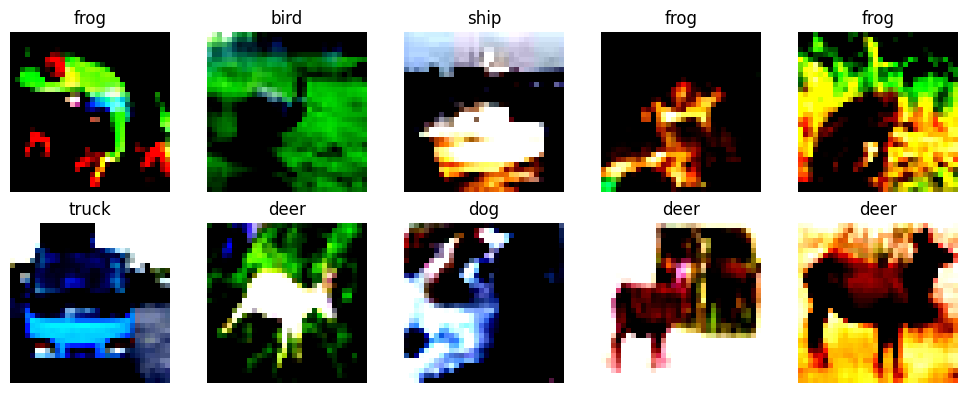

In [9]:
# Assuming class_names is a list of class names and train_data is your dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Create a 2x5 grid of subplots

for idx in range(10):
    ax = axes[idx // 5, idx % 5]  # Position in 2x5 grid
    image, label = train_dataset[idx]
    ax.imshow(image.permute(1, 2, 0))  # Permute for (H, W, C) format
    ax.set_title(class_names[label])
    ax.axis('off')  # Turn off axes for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [10]:
from collections import Counter

# Extract labels from train_data
labels = [label for label in train_data.targets]

# Count occurrences of each label
class_counts = Counter(labels)

# Display counts
print(class_counts)

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


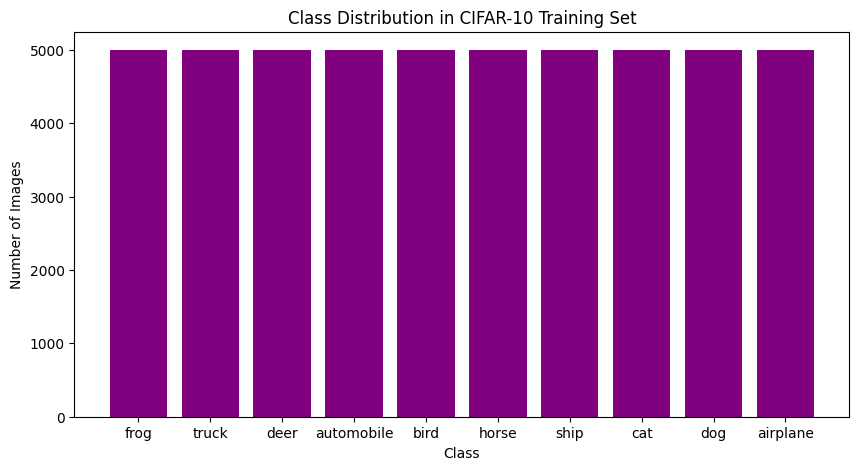

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# Get all labels from the training dataset
all_labels = [label for _, label in train_data]

# Count occurrences of each class label
label_counts = Counter(all_labels)

# Map label indices to class names
class_counts = {class_names[i]: count for i, count in label_counts.items()}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='purple')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.xticks(rotation=0)
plt.show()

## <font color = 'green'> **Comments on the images:**

1. Some objects in the images are extending to the edges of the image boundary, we should use padding to avoid any loss of data.
2. The data is equally balanced among the classes.

### <font color = 'Orange'>  **Data Loader**

Building the dataloader objects with a batch size of 32. This will be a hyperparamter that will be tweaked as per our requirement.

In [12]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
                            )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False
                             )

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1250 batches of 32
Length of validation dataloader: 313 batches of 32
Length of test dataloader: 313 batches of 32


# **Building a Basic CNN Model.**

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Model will have two blocks of [Convolution -> Relu -> Maxpooling2D] followed by a FcNN.**

In this model,

1. Convolution layer: Will help us to extract features from the images.
2. ReLU layer: Will introduce non-linearity in the model and help the model to understand more complex structure in our images.
3. MaxPooling layer: Will reduce the size of our feature map while keeping the most important features in our data.
4. Flatten layer: We are implementing the flatten operation using [x = x.view(x.size(0), -1)]. This will provide us with a single dimensional array of all the features in our last stack of feature maps.
5. Linear Layer: These are the layers of neurons in our model that will map the features identified in the convolution operations to the output classes, effectively working as a classifier.

In [14]:
class BasicCNN(nn.Module):
    def __init__(self, out_1, out_2, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fcnn1 = nn.Linear(out_2*8*8, 1000)
        self.fcnn2 = nn.Linear(1000, 500)
        self.fcnn3 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fcnn1(x)

        x = torch.relu(x)
        x = self.fcnn2(x)

        x = torch.relu(x)
        x = self.fcnn3(x)

        return x

### <font color = 'Orange'>  **Initializing the basic CNN model**

In [15]:
modelV0 = BasicCNN(out_1=32, out_2=64, num_classes=10)
modelV0

BasicCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcnn1): Linear(in_features=4096, out_features=1000, bias=True)
  (fcnn2): Linear(in_features=1000, out_features=500, bias=True)
  (fcnn3): Linear(in_features=500, out_features=10, bias=True)
)

In [16]:
summary(modelV0)

Layer (type:depth-idx)                   Param #
BasicCNN                                 --
├─Conv2d: 1-1                            2,432
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            51,264
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            4,097,000
├─Linear: 1-6                            500,500
├─Linear: 1-7                            5,010
Total params: 4,656,206
Trainable params: 4,656,206
Non-trainable params: 0

###<font color = 'orange'>**Down below is the visual representation of our BasicCNN model.**

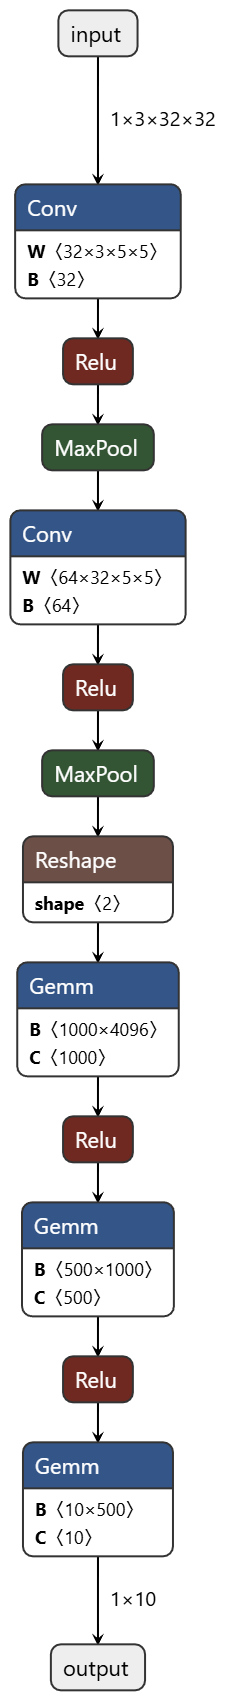

##<font color = 'green'> **Defining the loss function, optimizer and evaluation metric.**

1. **Loss function**: nn.CrossEntropyLoss: We have a multiclass classification problem, therefore a cross entorpy loss function is most appropriate.
2. **Optimizer**: torch.optim.SGD: The SGD (Stochastic Gradient Descent) optimizer provides robust performance for the task at hand.
3. **Evaluation metric**: Accuracy: Our dataset is balanced amongst all the classes. Therefore a simple metric like Accuracy will suffice.

In [19]:
accuracy_fn = Accuracy(task= 'multiclass' ,num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV0.parameters(),
                            lr=0.1)

Defining the train_step and test_step function. These will facilitate with training and evaluating our models for each epoch.

In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0.0, 0.0
    model.to(device)
    model.train()  # Ensure model is in training mode
    for batch, (X, y) in enumerate(data_loader):
        # Send data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Calculate accuracy
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        train_acc += acc.item()

        # 4. Optimizer zero grad
        optimizer.zero_grad()

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

    # Calculate average loss and accuracy per epoch
    avg_loss = train_loss / len(data_loader)
    avg_acc = train_acc / len(data_loader)
    print(f"Train loss: {avg_loss:.4f} | Train accuracy: {avg_acc*100:.2f}%")
    return avg_loss, avg_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0.0, 0.0
    model.to(device)
    model.eval()  # Put model in evaluation mode
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # 3. Calculate accuracy
            acc = accuracy_fn(y_pred.argmax(dim=1), y)
            test_acc += acc.item()

    # Calculate average loss and accuracy per epoch
    avg_loss = test_loss / len(data_loader)
    avg_acc = test_acc / len(data_loader)
    print(f"Validation loss: {avg_loss:.4f} | Validation accuracy: {avg_acc*100:.2f}%\n")
    return avg_loss, avg_acc


Training the Basic CNN model for 10 epochs. Validation dataset is used for evaluation during training.

This will serve as a Baseline model for us and guide the design decisions for our subsequent model.

### <font color = 'Orange'>  **Basic Model Training**

Epoch: 1/10
---------
Train loss: 1.5478 | Train accuracy: 44.33%
Validation loss: 1.2802 | Validation accuracy: 55.14%

Epoch: 2/10
---------
Train loss: 1.0712 | Train accuracy: 62.78%
Validation loss: 1.0339 | Validation accuracy: 63.08%

Epoch: 3/10
---------
Train loss: 0.7886 | Train accuracy: 72.64%
Validation loss: 0.8956 | Validation accuracy: 68.92%

Epoch: 4/10
---------
Train loss: 0.5616 | Train accuracy: 80.41%
Validation loss: 0.9744 | Validation accuracy: 69.50%

Epoch: 5/10
---------
Train loss: 0.3801 | Train accuracy: 86.68%
Validation loss: 1.0479 | Validation accuracy: 70.37%

Epoch: 6/10
---------
Train loss: 0.2614 | Train accuracy: 91.13%
Validation loss: 1.1683 | Validation accuracy: 69.40%

Epoch: 7/10
---------
Train loss: 0.1916 | Train accuracy: 93.77%
Validation loss: 1.3544 | Validation accuracy: 68.77%

Epoch: 8/10
---------
Train loss: 0.1545 | Train accuracy: 94.93%
Validation loss: 1.3655 | Validation accuracy: 69.25%

Epoch: 9/10
---------
Train loss

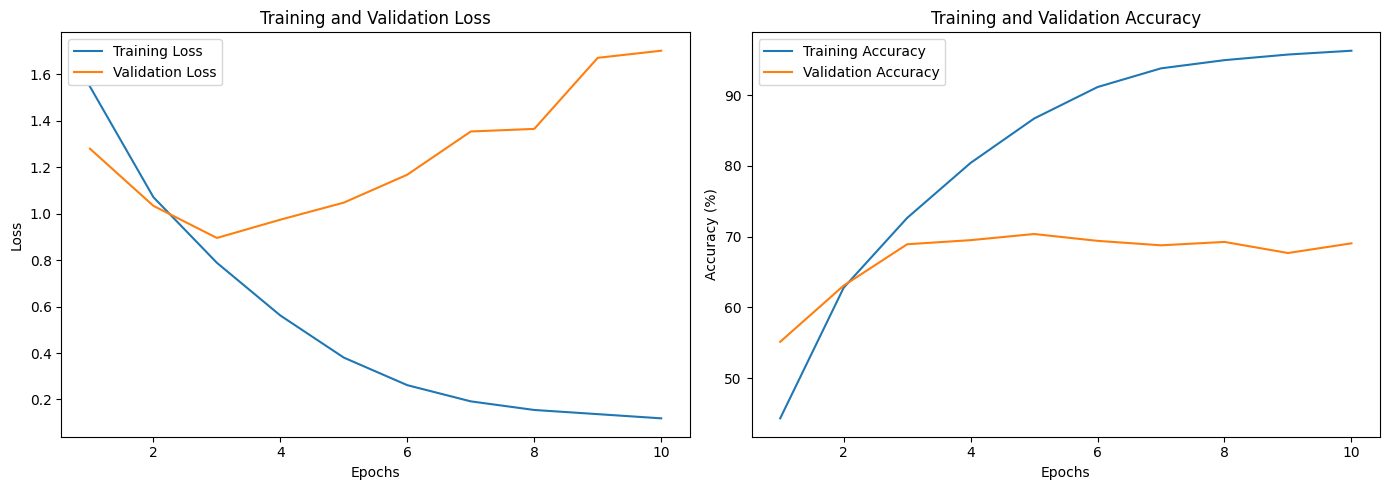

In [21]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

torch.manual_seed(42)

epochs = 10

# Create training and testing loop
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}\n---------")
    train_loss, train_acc = train_step(
        model=modelV0,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    val_loss, val_acc = test_step(
        model=modelV0,
        data_loader=val_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting the results
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accuracies], label='Training Accuracy')
plt.plot(epochs_range, [acc * 100 for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##<font color = 'green'>**Observations:**

<font color = 'green'>This output shows the training and validation metrics for a model over 10 epochs. Key observations include:
1. Training Loss and Accuracy: The model’s training loss steadily decreases, indicating that it is learning the patterns in the training data. Training accuracy also improves, reaching around 96%, which suggests strong performance on the training set.
2. Validation Loss and Accuracy: Validation loss initially decreases but then starts to increase after the 4th epoch. This phenomenon, where validation loss rises while training loss continues to drop, suggests overfitting. Despite the increase in validation loss, validation accuracy remains relatively stable, peaking around 70%.
3. Model Performance: The model performs well on the training data but generalizes less effectively to the validation set, as evidenced by the divergence in loss values.



# **Model Evaluation**

### <font color = 'Orange'> **Evaluation function for the test dataset**

<font color = 'green'> We will use precision, recall and f1 score to understand the model performance on each of the classes.

<font color = 'green'> This will also help us to understand the classes for which the model performs well and the classes for which the model struggles.

<font color = 'green'> Also, we will visualize the multiclass confusion matrix to summarize the model performance in a single visualization.

Classification Report:

              precision    recall  f1-score   support

    airplane       0.73      0.75      0.74      1000
  automobile       0.91      0.65      0.76      1000
        bird       0.58      0.62      0.60      1000
         cat       0.48      0.50      0.49      1000
        deer       0.64      0.68      0.66      1000
         dog       0.56      0.57      0.57      1000
        frog       0.74      0.75      0.74      1000
       horse       0.83      0.67      0.74      1000
        ship       0.78      0.83      0.80      1000
       truck       0.70      0.81      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



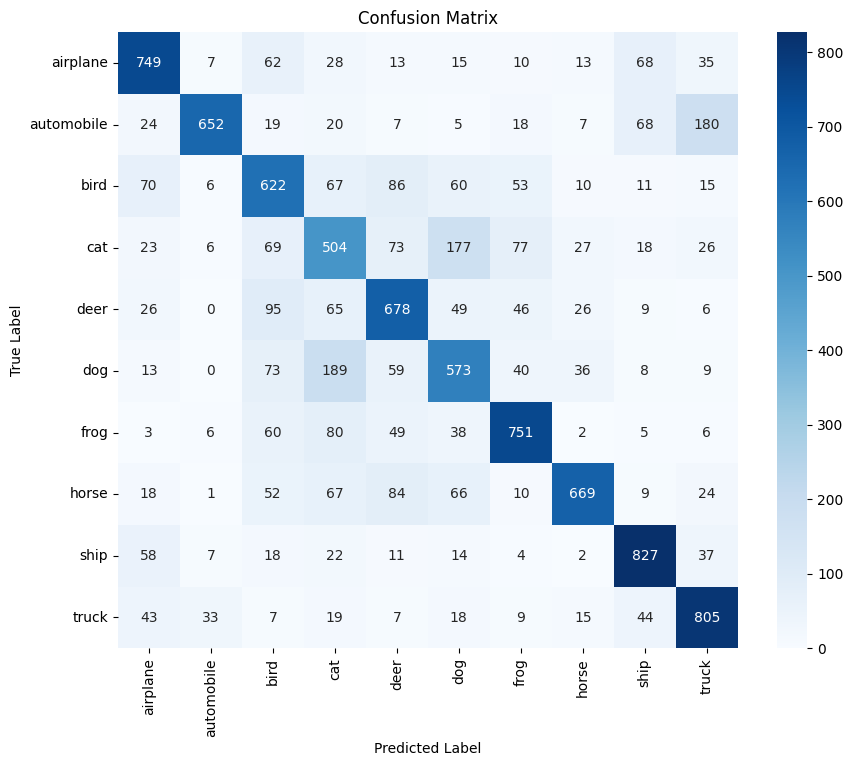

In [22]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        dict: Contains loss, accuracy, precision, recall, F1-score, and confusion matrix.
    """
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            preds = y_pred.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute average loss
    avg_loss = total_loss / len(data_loader)

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    return {
        "model_name": model.__class__.__name__,
        "model_loss": avg_loss,
        "model_acc": acc,
        "model_precision": precision,
        "model_recall": recall,
        "model_f1_score": f1_score,
        "confusion_matrix": cm,
    }

# Evaluate the model
results = eval_model(
    model=modelV0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    device=device
)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<font color = 'green'>The results of our model are super logical!

## <font color = 'green'>**Observations**:
1. The model does very well on classes like automobile, horse, ship and airplane.
2. The model seems to be confused between cats and dogs; deer and horse; truck and automobile.

<font color = 'green'>Overall, our model provides an accuracy of 69%. We will try and improve these results by building a better model.

#**Model Improvement section**

<font color = 'green'>Issues with Basic model:
1. **Overfitting**: The basic model is overfitting to the train dataset. We will introduce some regularization to avoid this issue.
2. **Simple architecture**: We will try to incorporate more layers and better layer configurations in the subsequent model to capture more information from our data and improve performance.
3. **Data Augmentation**: We will diversify our dataset by randomly adding noise in the data in the form of rotations, flips, sharpness variation, etc to help train a more robust model.
4. **Hyperparameter tuning**: We will run training loops on the model using different values of Batch Size and learning rate, momentum and try to gauge the best range of parameters to maximize the model performance.
5. **Train for More Epochs**: Since the loss and accuracy are still improving, training for more epochs might yield even better results.


### <font color = 'Orange'>**Transformation functions**

In [23]:
# Defining the transform function for our images. We are using transforms like rotations, flips, zooms and shifts to increase training data variability.
IMAGE_SIZE = 32

# These values are mostly used by researchers as found to very useful in fast convergence
mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]

# We can try various transformation for good generalization of model
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),   # Converting image to tensor
                                     transforms.Normalize(mean, std)])


composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

###<font color = 'green'>**Data Augmentation:**
<font color = 'green'>Data augmentation techniques are applied to the training images to increase the variability of the dataset, which helps improve the model’s generalization and robustness. We have used various data augmentation techniques in this model:
<font color = 'green'>
1. **Image Resizing**: transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)): Resizes all images to 32x32 pixels, which standardizes the input size across the dataset, ensuring uniformity in input dimensions for the model.
2. **Random Rotation**:transforms.RandomRotation(20): Randomly rotates some images by up to 20 degrees. This helps the model learn rotational invariance, improving its ability to recognize objects even if they appear at different angles.
3.	**Random Horizontal Flip**:transforms.RandomHorizontalFlip(0.1): Randomly flips images horizontally with a probability of 10%. This allows the model to learn that objects can appear mirrored, enhancing its ability to recognize horizontally symmetrical features.
4.	**Color Jitter**:transforms.ColorJitter: Adjusts the brightness, contrast, and saturation by a factor of 0.1. This variation in color properties teaches the model to focus less on color differences, making it more robust to lighting and contrast variations.
5.	**Random Adjust Sharpness**:transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1): Changes the sharpness of the image with a probability of 10%, simulating a range from slightly blurred to sharper images. This augmentation helps the model adapt to varying image qualities and focus on essential features.
6.	**Conversion to Tensor**:transforms.ToTensor(): Converts the augmented image to a PyTorch tensor, making it compatible with deep learning models.
7.	**Normalization**:transforms.Normalize(mean, std): Standardizes the pixel values based on the dataset’s mean and standard deviation. Normalization helps speed up convergence by bringing all pixel values into a similar range, which is essential for effective learning.



Dowloading and transforming the datasets.

In [24]:
# Setup training data
train_data = datasets.CIFAR10(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform= composed_train, # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform= composed_test
)

Files already downloaded and verified
Files already downloaded and verified


###<font color = 'Orange'> **Train and Validation split on the transformed datasets.**

In [25]:
from torch.utils.data import random_split

torch.manual_seed(42)

# Define the split ratio
train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

###<font color = 'Orange'> **Dataloader initialization.**

We have increased the Batch size to 64 to improve Generalization.

In [26]:
# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True
                            )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False
                             )

# Let's check out what we've created
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 625 batches of 64
Length of validation dataloader: 157 batches of 64
Length of test dataloader: 157 batches of 64


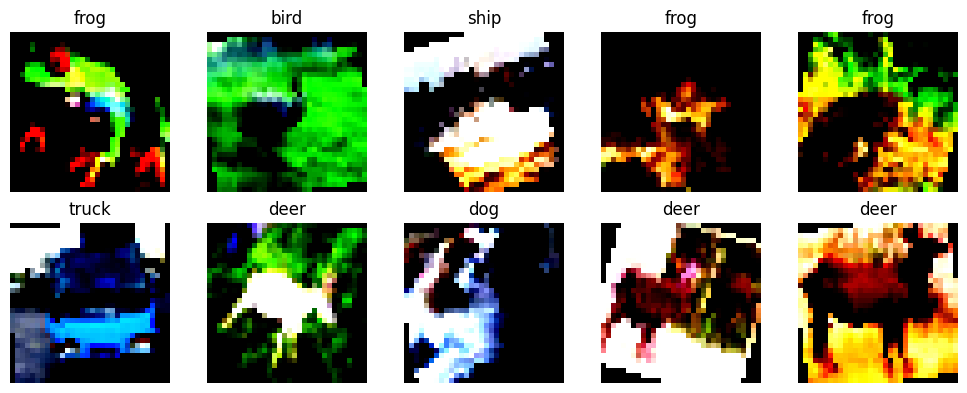

In [27]:
# Assuming class_names is a list of class names and train_data is your dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Create a 2x5 grid of subplots

for idx in range(10):
    ax = axes[idx // 5, idx % 5]  # Position in 2x5 grid
    image, label = train_dataset[idx]
    ax.imshow(image.permute(1, 2, 0))  # Permute for (H, W, C) format
    ax.set_title(class_names[label])
    ax.axis('off')  # Turn off axes for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# **Improved Model**

###<font color = 'Orange'> **Architecture:**

In [28]:
class BiggerCNN(nn.Module):
    def __init__(self, out_1, out_2, num_classes, p):
        super(BiggerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.conv3_bn = nn.BatchNorm2d(out_2)
        self.conv4 = nn.Conv2d(in_channels=out_2, out_channels=out_2, kernel_size=5, padding=2)
        self.conv4_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=out_2, out_channels=out_2, kernel_size=5, padding=2)
        self.conv5_bn = nn.BatchNorm2d(out_2)
        self.conv6 = nn.Conv2d(in_channels=out_2, out_channels=out_2, kernel_size=5, padding=2)
        self.conv6_bn = nn.BatchNorm2d(out_2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fcnn1 = nn.Linear(out_2*4*4, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fcnn2 = nn.Linear(1024, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fcnn3 = nn.Linear(128, num_classes)
        self.drop = nn.Dropout(p=p)
        self.drop_conv = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)

        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)

        x = self.conv5(x)
        x = self.conv5_bn(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = self.conv6_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)

        x = x.view(x.size(0), -1)
        x = self.fcnn1(x)
        x = self.fc1_bn(x)

        x = torch.relu(self.drop(x))
        x = self.fcnn2(x)
        x = self.fc2_bn(x)

        x = torch.relu(self.drop(x))
        x = self.fcnn3(x)

        return x

### <font color = 'green'> **Improvements made in Model's architecture:**
<font color = 'green'>The BiggerCNN model (modelV1) introduces several improvements over the previous model, aimed at enhancing performance and generalization.
1. **Increased Model Capacity**: The model has more convolutional layers (six total) with added batch normalization layers after each convolutional layer. This depth and regularization can capture more complex patterns and improve model stability.
2. **Batch Normalization**: Batch normalization layers after each convolutional and fully connected layer help normalize activations, accelerating training and reducing sensitivity to initialization and learning rate.
3. **Progressive Pooling Layers**: With three max-pooling layers, the model progressively reduces spatial dimensions. This approach helps to focus on essential features, reducing computational load while retaining relevant information.
4. **Dropout for Regularization**: Dropout layers with different dropout probabilities (0.3 for convolutional layers and a tunable dropout in fully connected layers) are included to mitigate overfitting, improving generalization by randomly disabling neurons during training.
5. **Larger Fully Connected Layers**: The final fully connected (FC) layers consist of larger hidden dimensions (1024 and 128 units) before the output layer, allowing for richer feature representations.

In [29]:
modelV1 = BiggerCNN(out_1=64, out_2=128, num_classes=10, p = 0.5)
summary(modelV1)

Layer (type:depth-idx)                   Param #
BiggerCNN                                --
├─Conv2d: 1-1                            4,864
├─BatchNorm2d: 1-2                       128
├─Conv2d: 1-3                            102,464
├─BatchNorm2d: 1-4                       128
├─MaxPool2d: 1-5                         --
├─Conv2d: 1-6                            204,928
├─BatchNorm2d: 1-7                       256
├─Conv2d: 1-8                            409,728
├─BatchNorm2d: 1-9                       256
├─MaxPool2d: 1-10                        --
├─Conv2d: 1-11                           409,728
├─BatchNorm2d: 1-12                      256
├─Conv2d: 1-13                           409,728
├─BatchNorm2d: 1-14                      256
├─MaxPool2d: 1-15                        --
├─Linear: 1-16                           2,098,176
├─BatchNorm1d: 1-17                      2,048
├─Linear: 1-18                           131,200
├─BatchNorm1d: 1-19                      256
├─Linear: 1-20       

###<font color = 'orange'>**Down below is the visual representation of our BiggerCNN model.**

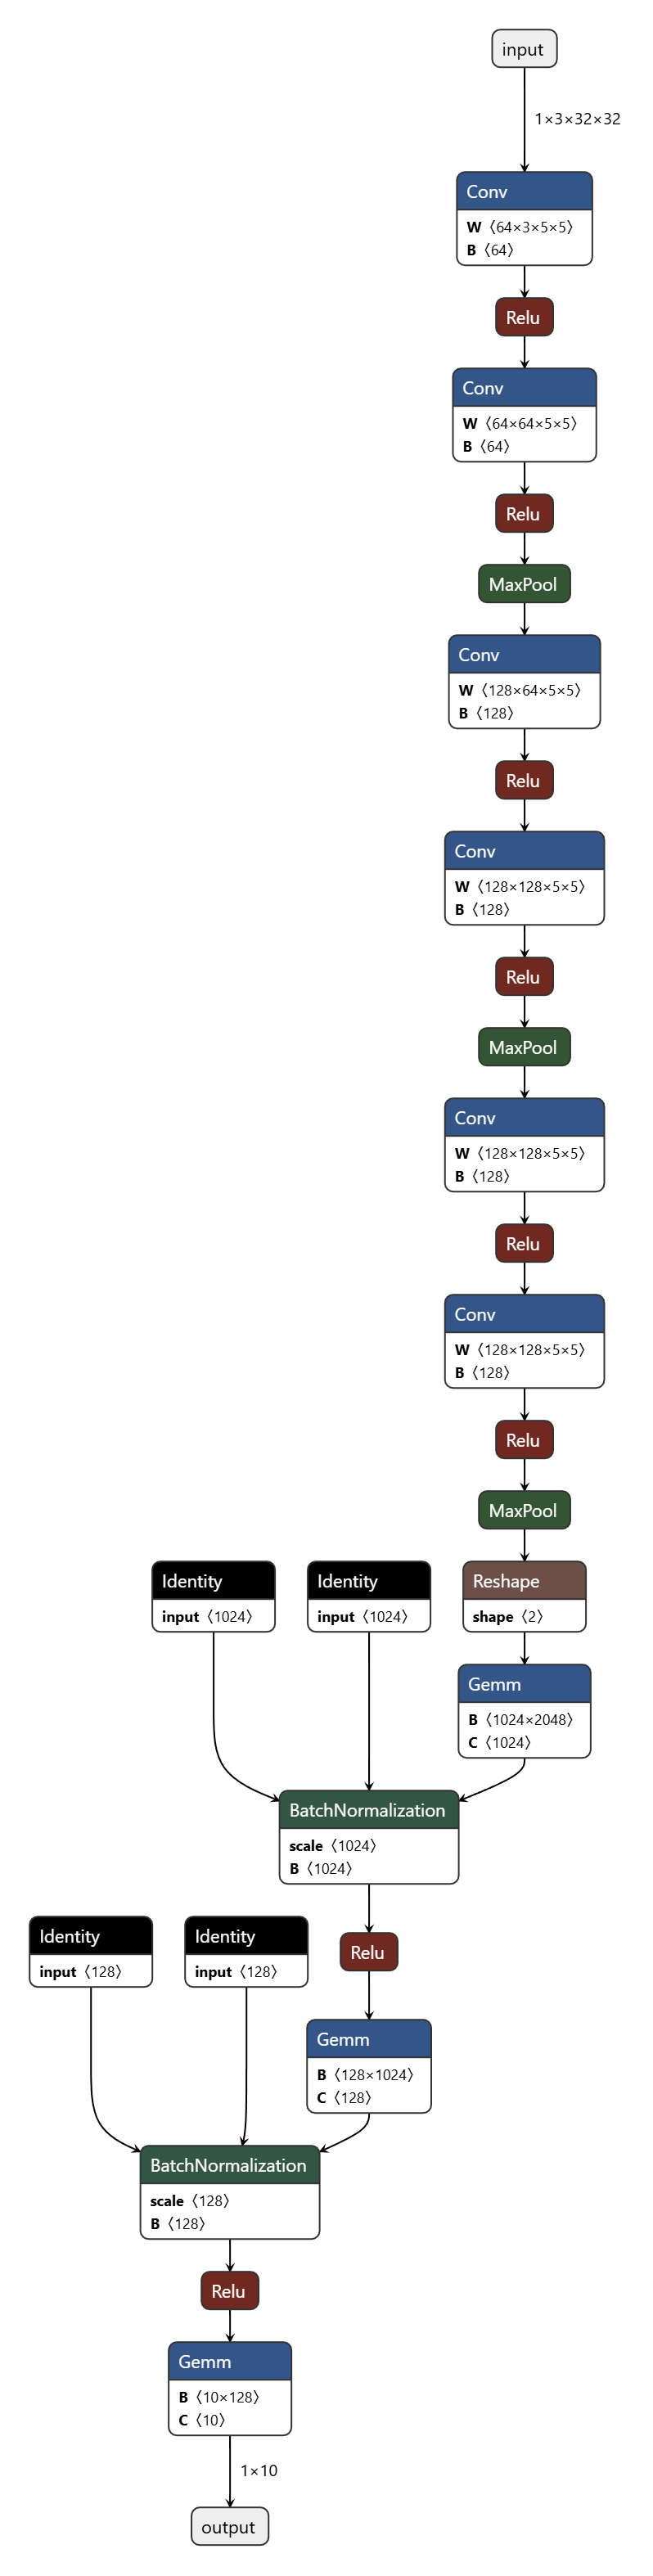

# **Training the Improved model.**

Epoch: 1/40, Learning Rate: 0.01500
---------
Train loss: 1.7313 | Train accuracy: 35.40%
Validation loss: 1.4523 | Validation accuracy: 46.45%

New best model saved with validation loss: 1.4523
Epoch: 2/40, Learning Rate: 0.03000
---------
Train loss: 1.4241 | Train accuracy: 48.40%
Validation loss: 1.1526 | Validation accuracy: 58.51%

New best model saved with validation loss: 1.1526
Epoch: 3/40, Learning Rate: 0.04500
---------
Train loss: 1.2306 | Train accuracy: 56.79%
Validation loss: 1.0834 | Validation accuracy: 61.27%

New best model saved with validation loss: 1.0834
Epoch: 4/40, Learning Rate: 0.06000
---------
Train loss: 1.1166 | Train accuracy: 61.41%
Validation loss: 1.0664 | Validation accuracy: 62.78%

New best model saved with validation loss: 1.0664
Epoch: 5/40, Learning Rate: 0.07500
---------
Train loss: 1.0585 | Train accuracy: 63.70%
Validation loss: 0.9538 | Validation accuracy: 66.63%

New best model saved with validation loss: 0.9538
Epoch: 6/40, Learning Rat

<ipython-input-30-71611a74d15d>:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelV1.load_state_dict(torch.load("best_model.pth"))


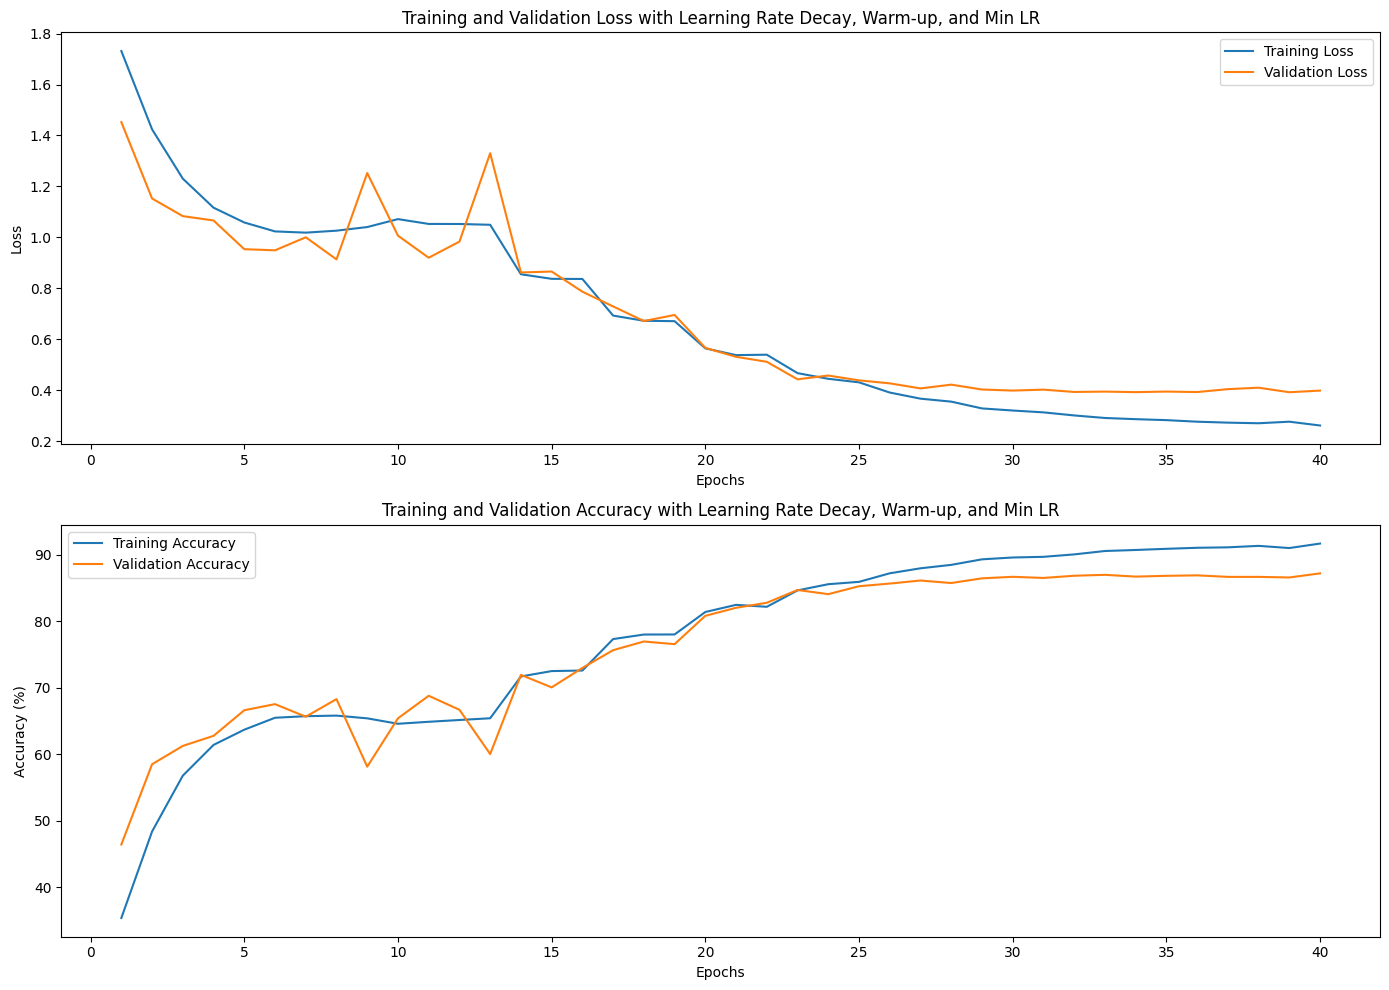

In [ ]:
import torch
from torch.optim.lr_scheduler import LambdaLR

# Parameters
lr = 0.15
epochs = 40
warmup_steps = 10      # Number of epochs for the warm-up phase
min_factor = 0.01     # Minimum learning rate as a fraction of the initial learning rate (e.g., 1% of lr)

# Initialize metrics storage
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

torch.manual_seed(42)

accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.SGD(modelV1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Define warm-up function with a minimum learning rate
def lr_lambda(epoch):
    if epoch < warmup_steps:
        # Linear warm-up phase
        return (epoch + 1) / warmup_steps
    else:
        # Decay phase after warm-up with min_factor as the lower bound
        return max(min_factor, 0.5 ** ((epoch - warmup_steps) // 3))  # Matches `StepLR(step_size=3, gamma=0.5)`

# Combine warm-up and StepLR with LambdaLR
scheduler = LambdaLR(optimizer, lr_lambda)

# Initialize variable to keep track of the best validation loss
best_val_loss = float('inf')

# Training and validation loop
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}, Learning Rate: {scheduler.get_last_lr()[0]:.5f}\n---------")

    # Training step
    train_loss, train_acc = train_step(
        model=modelV1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    # Validation step
    val_loss, val_acc = test_step(
        model=modelV1,
        data_loader=val_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # Update the best validation loss
        torch.save(modelV1.state_dict(), "best_model.pth")  # Save the model's state_dict
        print(f"New best model saved with validation loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step()

# After training, load the best model for evaluation or further use
modelV1.load_state_dict(torch.load("best_model.pth"))

# Plot the results
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 10))

# Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Learning Rate Decay, Warm-up, and Min LR')
plt.legend()

# Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accuracies], label='Training Accuracy')
plt.plot(epochs_range, [acc * 100 for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy with Learning Rate Decay, Warm-up, and Min LR')
plt.legend()

plt.tight_layout()
plt.show()

###<font color = 'green'>**In Training modelV1 we made a few improvements like:**</br>
1. Increasing the training epochs from 10 to 40, to learn and refine its understanding of the data over a longer period, leading to improved performance.  With more epochs, the model has more opportunities to adjust its weights based on the training data, allowing it to capture complex patterns that might not be fully learned in only 10 epochs.
2. **Learning Rate Scheduling with Warm-up and Minimum LR Decay**:</br>
<font color = 'green'> **Warm-up Phase**: The learning rate gradually increases for the first 10 epochs, allowing the model to “warm up” and avoid large updates that could destabilize training.</br>
<font color = 'green'> **Minimum LR Decay**: After the warm-up phase, the learning rate decays exponentially every 3 epochs, preventing overfitting by reducing the learning rate progressively. </br>This combination of warm-up and decay with a minimum threshold ensures more stable convergence and better generalization.
3. Selecting the model with the lowest validation loss as the best model, rather than simply using the model from the final epoch, as a strategy aimed at achieving optimal generalization on new data.


###<font color = 'green'>**Observations:**
1. **Training Loss and Accuracy**: The model reaches a low training loss of around 0.26 and high accuracy of about 91.68%, indicating a strong ability to learn patterns within the training data.
2. **Validation Loss and Accuracy**: The validation loss fluctuates but ultimately achieves a best validation loss of 0.3924 with an accuracy of 87.20%. These values suggest the model is achieving good generalization, maintaining close alignment between training and validation metrics.
3. This model, trained over 40 epochs, demonstrates significant improvements in both validation loss and accuracy compared to the second model, trained over just 10 epochs. This extended training duration, combined with a gradual learning rate decay, contributes to a more balanced and generalizable performance.
4. One of the most notable improvements is in validation loss. The improvement model (modelV1) achieves a best validation loss of 0.3924, whereas the basic model's(modelv0) validation loss ends at a much higher 1.2172. This substantial reduction in validation loss (about 67.7%) suggests that the modelV1 model is far better at learning patterns that generalize well to new, unseen data, rather than merely fitting the training set.
5. Similarly, in terms of validation accuracy, the modelV1 reaches 87.20%, while the modelV0 lags at 69.75%. This improvement of around 17.5% in validation accuracy reinforces that the modelV1 not only learns more generalizable patterns but also makes significantly more accurate predictions on the validation set.
6. In contrast, the modelV0 shows signs of overfitting, with a very high training accuracy of 96.33% but much poorer validation performance. This disparity indicates that, while the modelV0 fits the training data extremely well, it struggles to generalize effectively. In comparison, the modelV1 maintains a more balanced training accuracy of 91.68%, suggesting a more controlled fit that aligns better with the validation set.



###<font color = 'Orange'>**Improved Model's Evaluation on Test data**

<ipython-input-31-57b3eb46ff23>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelV1.load_state_dict(torch.load("best_model.pth"))


Classification Report:

              precision    recall  f1-score   support

    airplane       0.91      0.90      0.90      1000
  automobile       0.95      0.96      0.96      1000
        bird       0.87      0.85      0.86      1000
         cat       0.80      0.75      0.77      1000
        deer       0.87      0.91      0.89      1000
         dog       0.82      0.83      0.82      1000
        frog       0.90      0.94      0.92      1000
       horse       0.92      0.92      0.92      1000
        ship       0.93      0.95      0.94      1000
       truck       0.94      0.92      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



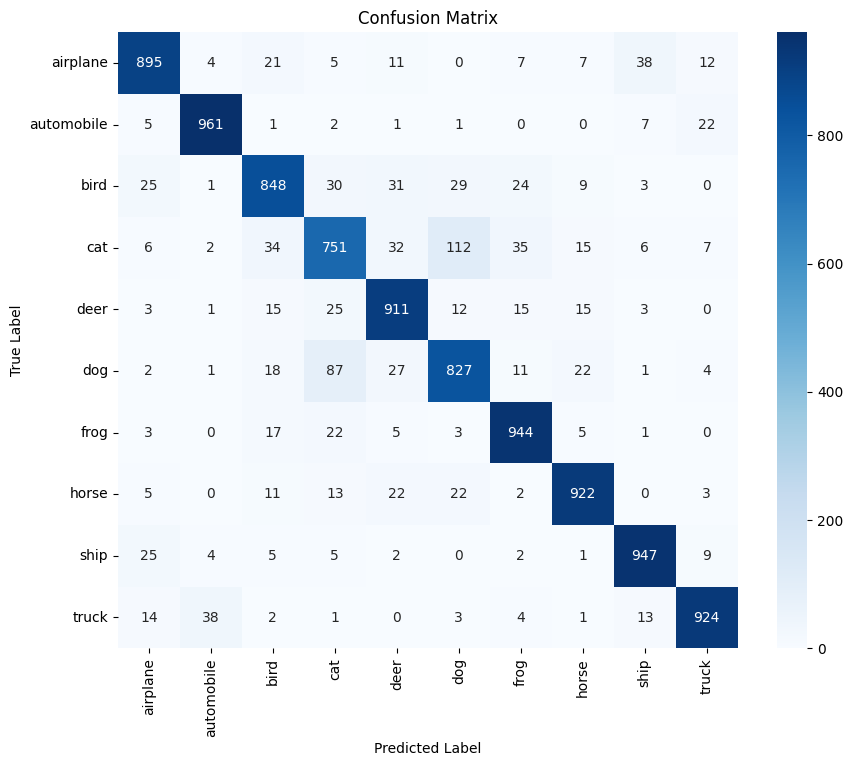

In [ ]:
# Load the best model
modelV1.load_state_dict(torch.load("best_model.pth"))

# Evaluate the best model on the test dataset
results_test = eval_model(
    model=modelV1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    device=device
)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results_test['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<font color = 'green'>This classification report shows the performance of a model across 10 different classes, each with 1,000 samples.
<font color = 'green'>
1.	**Overall Accuracy**: The model achieves an accuracy of 0.89, meaning it correctly predicts 89% of the test samples, indicating a generally strong performance across the dataset.
2.	**Class Performance**:
<font color = 'green'></br> **High Performance Classes**: The model performs exceptionally well in classes like automobile and ship, achieving both high precision (0.95–0.96) and recall (0.95–0.96). This suggests that the model makes few false positives and can reliably detect these classes.</br>
<font color = 'green'>  **Balanced Performance Classes**: Classes like airplane, bird, deer, frog, horse, and truck have precision, recall, and F1-scores around 0.90. This balance indicates that the model is reliable for these classes, making accurate predictions without a strong bias toward false positives or false negatives.</br>**Moderate Performance Classes**: The cat and dog classes have slightly lower F1-scores (0.77 and 0.82, respectively). These lower scores suggest the model may find it more challenging to distinguish these classes, likely due to the subtle and overlapping visual features typical between animals.
3.	Averages:</br>**Macro Average**: Precision, recall, and F1-score average to 0.89 across all classes. This shows that the model performs consistently well across classes, without significant bias toward any single class.</br> **Weighted Average**: Also at 0.89, the weighted average reflects similar high performance across all classes when adjusted for the support (the number of instances per class).


 ### <font color = 'green'> **Observations from Confusion matrix:**
  1. Misclassifications:</br>
  •Cats and Dogs: The model still misclassifies 87 cats as dogs and 27 dogs as cats, likely due to the visual similarities between these classes.</br>
  •Birds and Cats: The model incorrectly identifies 34 cats as birds and 30 birds as cats, suggesting that these classes may share features that are challenging for the model to differentiate.</br>
  •Trucks and Automobiles: 38 trucks are misclassified as automobiles, which could be due to structural similarities.</br>
  2. **High Accuracy in Certain Classes**: The model performs particularly well in classes like automobiles and ships, with minimal misclassifications, indicating it is effective at identifying these classes.
	3. **Class Confusion**: Compared to the previous confusion matrix, misclassifications have been reduced but still persist in certain classes with visually similar features. For instance, the model continues to confuse some animals, such as cats, dogs, and birds, as well as vehicles like trucks and automobiles. While overall accuracy has improved, these specific areas of confusion remain, indicating further room for refinement in distinguishing between these closely related classes.